# Setup

Setting up environment by importing necessary libraries and initializing Spark.

In [2]:
from local_install import setup_environment
setup_environment()

In [3]:
import folium
import pyspark
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import numpy as np
import os
%pylab inline
%pylab notebook

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [4]:
sc = pyspark.SparkContext()
sql = pyspark.sql.SQLContext(sc)

Load data into dataframes.

In [5]:
root_path = "./data"

# file_struct objects
com_file = {'header': "cm_header_file.csv", 'data': "cm.txt" }
can_file = {'header': "cn_header_file.csv", 'data': "cn.txt" }
com_can_link_file = {'header': "ccl_header_file.csv", 'data': "ccl.txt" }
indv_file = {'header': "indiv_header_file.csv", 'data': "itcont.txt" }
pas_file = {'header': "pas2_header_file.csv", 'data': "itpas2.txt" }
com_links_file = {'header': "oth_header_file.csv", 'data': "itoth.txt" }

def load_header(filename):
    """
    Given a header .csv file, return a list containing the names of all columns in the table.
    
    Input:
    filename: a string specifying the header .csv file to load
    
    Output:
    A list containing column names of the table
    """
    with open(filename, "r") as f:
        return [r.replace('\r\n','') for r in f.readline().split(",")]
    
def load_dataframe(file_struct):
    """
    Given a dictionary representing the locations of FEC raw files corresponding to a table,
    load the tables into a Spark DataFrame.
    
    Input:
    file_struct: a dictionary containing the keys 'header' and 'data', where
     'header' contains the name of the `.csv` file specifying the table header file, and
     'data' contains the name of the `.txt` file specifying the table data file
     
    Output:
    A DataFrame which contains the loaded data.
    """
    df = None
    
    lines = sc.textFile(root_path + "/" + file_struct['data'])
    data = lines.map(lambda x: tuple(cell.strip() for cell in x.split("|")))
    
    fields = [StructField(field_name, StringType(), True) for field_name in load_header(root_path + "/" + file_struct['header'])]
    schema = StructType(fields)
    
    df = sql.createDataFrame(data, schema)
    return df.cache()

Initialize dataframes and register temporary SQL tables.

In [6]:
com = load_dataframe(com_file)
can = load_dataframe(can_file)
links = load_dataframe(com_can_link_file)
indv = load_dataframe(indv_file)
pas = load_dataframe(pas_file)
com_links = load_dataframe(com_links_file)

In [7]:
com.registerTempTable("com")
can.registerTempTable("can")
links.registerTempTable("links")
indv.registerTempTable("indv")
pas.registerTempTable("pas")
com_links.registerTempTable("com_links")

# Data Exploration

Let's query for information corresponding to the strings "Clinton", "Sanders", "Trump", and "Cruz".

In [8]:
front_runners = sql.sql("""
SELECT CAND_ID, CAND_NAME, CAND_STATUS, CAND_OFFICE
FROM can
WHERE CAND_NAME LIKE "%CLINTON%"
OR CAND_NAME LIKE "%SANDERS%"
OR CAND_NAME LIKE "%TRUMP%"
OR CAND_NAME LIKE "%CRUZ%"
""")
front_runners.registerTempTable("fr")
front_runners.show(truncate=False)

+---------+-----------------------------------+-----------+-----------+
|CAND_ID  |CAND_NAME                          |CAND_STATUS|CAND_OFFICE|
+---------+-----------------------------------+-----------+-----------+
|H2CA24153|THAYNE, DAVID CRUZ                 |P          |H          |
|H2MI08105|HETRICK, BRIAN CLINTON             |N          |H          |
|H2TX33123|SANDERS, KENNETH                   |P          |H          |
|H6HI01287|DELACRUZ SANTIAGO OSTROV, SHIRLENE |N          |H          |
|H6NY05051|SANDERS, JAMES JR                  |C          |H          |
|H6NY09137|SANDERS, JAIME                     |N          |H          |
|H8OH02041|SANDERS, CHARLES W                 |P          |H          |
|P00003392|CLINTON, HILLARY RODHAM            |C          |P          |
|P60006111|CRUZ, RAFAEL EDWARD "TED"          |C          |P          |
|P60007168|SANDERS, BERNARD                   |C          |P          |
|P60012184|BALLSACK, DONALD TRUMP'S HAIRY KING|N          |P    

Our query results in more candidates than the ones we are looking for. To extract the front-runners we filter using the candidate's office and status.

In [9]:
front_runners = sql.sql("""
SELECT CAND_ID, CAND_NAME, CAND_PCC
FROM can
WHERE CAND_STATUS="C" AND CAND_OFFICE="P" AND 
( CAND_NAME LIKE "%CLINTON%"
OR CAND_NAME LIKE "%SANDERS%"
OR CAND_NAME LIKE "%TRUMP%"
OR CAND_NAME LIKE "%CRUZ%") 
""")
front_runners.registerTempTable("front_runners")
q1 = front_runners.select("CAND_ID", "CAND_NAME", "CAND_PCC")
q1.show(truncate=False)

+---------+-------------------------+---------+
|CAND_ID  |CAND_NAME                |CAND_PCC |
+---------+-------------------------+---------+
|P00003392|CLINTON, HILLARY RODHAM  |C00575795|
|P60006111|CRUZ, RAFAEL EDWARD "TED"|C00574624|
|P60007168|SANDERS, BERNARD         |C00577130|
|P80001571|TRUMP, DONALD J.         |C00580100|
+---------+-------------------------+---------+



The following query gives us the number of contributions by individuals that each front-runner's principal campaign committee has received.

In [10]:
num_indv_contributions = sql.sql("""
SELECT CAND_ID, CAND_NAME, COUNT(*) AS count
FROM indv JOIN front_runners ON CAND_PCC=CMTE_ID
GROUP BY CAND_ID,CAND_NAME
""")

q2 = num_indv_contributions.select("CAND_ID", "CAND_NAME", "count")
q2.show(truncate=False)

+---------+-------------------------+------+
|CAND_ID  |CAND_NAME                |count |
+---------+-------------------------+------+
|P60006111|CRUZ, RAFAEL EDWARD "TED"|427898|
|P80001571|TRUMP, DONALD J.         |40204 |
|P60007168|SANDERS, BERNARD         |882781|
|P00003392|CLINTON, HILLARY RODHAM  |406413|
+---------+-------------------------+------+



... and the total amount corresponding to these contributions. 

In [11]:
indv_contributions_amt = sql.sql("""
SELECT CAND_ID, CAND_NAME, SUM(TRANSACTION_AMT) AS SUM
FROM indv JOIN front_runners ON CAND_PCC=CMTE_ID
GROUP BY CAND_ID,CAND_NAME
""")

q3 = indv_contributions_amt.select("CAND_ID", "CAND_NAME", "SUM")
q3.show(truncate=False)

+---------+-------------------------+-----------+
|CAND_ID  |CAND_NAME                |SUM        |
+---------+-------------------------+-----------+
|P60006111|CRUZ, RAFAEL EDWARD "TED"|5.6260943E7|
|P80001571|TRUMP, DONALD J.         |1.4911975E7|
|P60007168|SANDERS, BERNARD         |6.0064248E7|
|P00003392|CLINTON, HILLARY RODHAM  |1.5295141E8|
+---------+-------------------------+-----------+



This query shows the committees linked to each of the front-runners. 

In [12]:
linked_committees = sql.sql("""
SELECT fr.CAND_ID, CAND_NAME, l.CMTE_ID, CMTE_NM
FROM front_runners fr
JOIN links l
ON fr.CAND_ID = l.CAND_ID
JOIN com c
ON l.CMTE_ID = c.CMTE_ID
""")

q4 = linked_committees.select("CAND_NAME", "CAND_ID", "CMTE_ID", "CMTE_NM")
q4.show(truncate=False)

+-------------------------+---------+---------+-------------------------------------------------------------------------------+
|CAND_NAME                |CAND_ID  |CMTE_ID  |CMTE_NM                                                                        |
+-------------------------+---------+---------+-------------------------------------------------------------------------------+
|CLINTON, HILLARY RODHAM  |P00003392|C00577395|PEOPLE IN COMMAND/PIC                                                          |
|TRUMP, DONALD J.         |P80001571|C00621672|VERMONT TRUMP DELEGATE FUND                                                    |
|SANDERS, BERNARD         |P60007168|C00590646|NEW YORK CAPITAL REGION FOR BRINGING ECONOMIC REVOLUTION NOW INSPIRING EVERYONE|
|SANDERS, BERNARD         |P60007168|C00612549|LORAIN COUNTY FORWARD                                                          |
|CLINTON, HILLARY RODHAM  |P00003392|C00575795|HILLARY FOR AMERICA                                      

... the number of contributions by committees that each front-runner has received

In [13]:
num_com_contributions = sql.sql("""
SELECT CAND_NAME, COUNT(*) AS count
FROM pas JOIN front_runners ON pas.CAND_ID = front_runners.CAND_ID
GROUP BY CAND_NAME
""")

q5 = num_com_contributions.select("CAND_NAME", "count")
q5.show(truncate=False)

+-------------------------+-----+
|CAND_NAME                |count|
+-------------------------+-----+
|CLINTON, HILLARY RODHAM  |6567 |
|TRUMP, DONALD J.         |1921 |
|SANDERS, BERNARD         |2250 |
|CRUZ, RAFAEL EDWARD "TED"|1581 |
+-------------------------+-----+



... and the total amount corresponding to these contributions

In [14]:
com_contributions_amt = sql.sql("""
SELECT CAND_NAME, SUM(TRANSACTION_AMT) AS SUM
FROM pas JOIN front_runners ON pas.CAND_ID = front_runners.CAND_ID
GROUP BY CAND_NAME
""")

q6 = com_contributions_amt.select("CAND_NAME", "SUM")
q6.show(truncate=False)

+-------------------------+-----------+
|CAND_NAME                |SUM        |
+-------------------------+-----------+
|CLINTON, HILLARY RODHAM  |2.4628653E7|
|TRUMP, DONALD J.         |4.4360356E7|
|SANDERS, BERNARD         |4410791.0  |
|CRUZ, RAFAEL EDWARD "TED"|2.880968E7 |
+-------------------------+-----------+



# Clustering Analysis. K-Means

Distributed version of K-Means++ clustering using PySpark.

### Initialization

In [15]:
def initialize_centers_plus(points, k):
    """
    Find k initial cluster centers using distributed weighted reservoir sampling.
    
    Inputs:
    points: a collection of d-dimensional points (x_1, x_2, ..., x_d).
    k: the number of cluster centers wanted
    
    Output:
    A list of k points which become the initial centers in K-means clustering
    """
    centers = []
    
    # Choose first center uniformly at random
    data = points.map(lambda x: x)
    centers.append(data.takeSample(False,1)[0])
    
    for _ in range(1, k):
        # Compute distances of each point to its nearest center
        key_points = data.map(lambda x: ((np.random.random())**(1.0 / (1e-7 + nearest_center(centers, x)[1])), x))
        
        # Given distances, choose a new center
        partition_centers = key_points.mapPartitions(choose_partition_center)
        new_center = partition_centers.reduce(pick_between_centers)
        centers.append(new_center[0])
        
    return centers

In [16]:
def choose_partition_center(points_partition_iterator):
    """
    Choose a single center from a SINGLE PARTITION, using weighted random sampling.
    
    Inputs:
    points_partition_iterator: an iterator through a partition of 2-tuples containing points and its 
    weighted random sampling key.
    
    Output:
    (As an iterator) A 2-tuple, containing the randomly-chosen center and its weighted random-sampling key
    """
    key, center = points_partition_iterator.next()

    for p_key, point in points_partition_iterator:
        if p_key > key:
            key = p_key
            center = point

    yield (center, key)

In [17]:
def pick_between_centers(candidate_center_1, candidate_center_2):
    """
    Between two centers from different partitions, pick the one with a larger key.
    
    Inputs:
    candidate_center_1: a 2-tuple, containing the randomly-chosen center and its weighted random sampling key 
                        from the first partition
    candidate_center_2: a 2-tuple, containing the randomly-chosen center and its weighted random sampling key 
                        from the second partition
    
    Output:
    A 2-tuple, containing the "better" center and its weighted random-sampling key
    """
    better_center = candidate_center_1 if candidate_center_1[1] > candidate_center_2[1] else candidate_center_2
    
    return better_center

In [18]:
def nearest_center(centers, point):
    """
    Given a point and a list of centers (also points), determine the center closest to that point,
    and compute the distance to that point.
    
    Inputs:
    centers: a list of points which represent the current centers
    point: the point to examine
    
    Outputs:
    A 2-tuple, containing the index of the closest center (point) and its distance from point
    """
    distances = np.linalg.norm(np.asarray(centers) - point, axis=1)
    index = np.argmin(distances)
    shortest_distance = distances[index]
    
    return (index, shortest_distance)

### Main Loop

In [20]:
def k_means(points,
            k = 4,
            initial_centers = None,
            max_iterations = 100,
            initializer = initialize_centers_plus,
            epsilon = 0.001):
    """
    Executes the K-means algorithm on a collection of points.
    
    Inputs:
    points: a collection of d-dimensional points (x_1, x_2, ..., x_d).
    k: the number of cluster centers wanted
    initial_centers: if supplied, skips the initialization phase and uses points from this value
    max_iterations: the maximum number of main-loop iterations to run
    initializer: a function which selects initial centers (if none supplied)
    epsilon: the threshhold at which convergence is reached and the algorithm halted
    
    Output:
    A list of k candidate cluster centers
    """
    
    # speeds up rerunning
    points.cache()
    
    old_centers = None
    new_centers = None
    if initial_centers: # we were provided initial centers to use
        new_centers = initial_centers
    else: # we need to initialize the centers ourselves
        new_centers = initializer(points, k)

        
    iteration = 0
    while not has_converged(old_centers, new_centers, epsilon) and iteration < max_iterations:
        # update centers
        old_centers = new_centers
        stats = points.mapPartitions(lambda x: compute_new_center_statistics(x, old_centers)).reduce(add_statistics)
        for i in range(len(stats[0])):
            new_centers[i] = np.divide(stats[1][i], stats[0][i])
        
        iteration += 1
        
    return new_centers

In [21]:
def compute_new_center_statistics(iterator, old_centers):
    """
    Given an iterator over points and a list of old centers, compute the statistics for the new center.
    
    Input:
    iterator: an iterator over points
    old_centers: a list of centers (points) from the previous iteration
    
    Output:
    A 2-tuple (counts, sums) consisting of:
     - counts: an array of length k containing the count of points in each new center
     - sums: a k by d array consisting of sum of the points assigned to each center
     
    Note that from the tuple you could compute the ith new center:
      sums[i] / counts[i]
    """
    # Get the shape of the old centers
    k = len(old_centers)
    d = len(old_centers[0])
    
    # Initialize the sums
    counts = [0] * k
    sums = [np.zeros(d)] * k
    
    # Loop over the data and compute the new assignments
    for point in iterator:
        # Compute the nearest center (you just implemented this!)
        index, _ = nearest_center(old_centers, point)
        # Update the sums and counts
        counts[index] += 1
        sums[index] = np.add(sums[index], point)
        
    yield (counts, sums)

In [22]:
def add_statistics(stats_1, stats_2):
    """
    Given statistics from two partitions, add those statistics.
    """
    # Compute stats_1 + stats_2
    for i in range(len(stats_1[0])):
        stats_1[0][i] += stats_2[0][i]
        stats_1[1][i] = np.add(stats_1[1][i], stats_2[1][i])
    
    return stats_1

In [23]:
def has_converged(old_centers, new_centers, epsilon):
    """
    Test if the distance between the centers is less than epsilon.
    """
    return (old_centers is not None) and (new_centers is not None) and \
        np.linalg.norm(np.asarray(old_centers) - np.asarray(new_centers), ord=2) < epsilon

### Testing implementation. Plotting Clusters

In [32]:
colors = ['ro', 'bo', 'go', 'yo']

def plot_clusters(centers, plt):
    for i in range(len(centers)):
        cluster = df.rdd.filter(lambda x: nearest_center(centers, x)[0] == i)
        cluster_sample = np.asarray(cluster.sample(False, 0.2).collect())
        plt.plot(cluster_sample[:,0], cluster_sample[:,1], colors[i])

In [33]:
df = sql.read.parquet("toy_data")

<IPython.core.display.Javascript object>


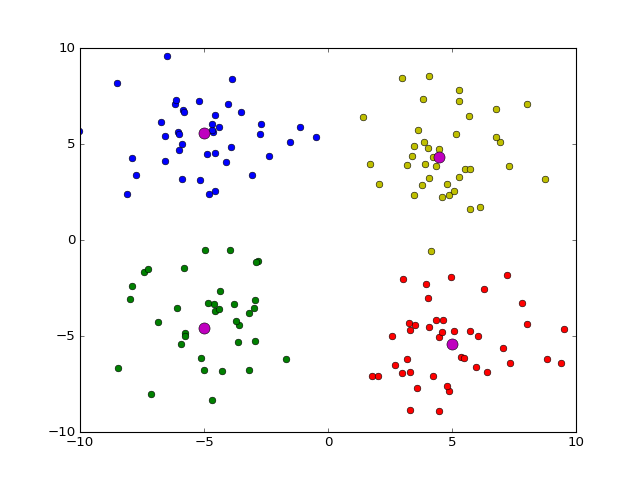

In [35]:
plt.figure()
plt.axis([-10, 10, -10, 10])

centers = k_means(df, 4)
plot_clusters(centers, plt)

centers = np.asarray(centers)
plt.plot(centers[:,0], centers[:,1], 'mo', markersize = 10)

# Geographical Contribution Clustering

First let's load the required data files.

In [36]:
zip_codes = sql.read.parquet("zip_codes")